# Random forest

As we saw in the previous notebook `1_Best_Model`, the best model to solve our problem is a **Random Forest Classifier**.

## Import libraries

In [1]:
# Linear algebra
import numpy as np 

# Data processing
import pandas as pd 

# Regex
import re

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 8, 6
plt.style.use('tableau-colorblind10')

# Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Machine learning
from sklearn.model_selection import train_test_split
from sklearn import tree

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# Grid Search
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score

## Load data

In [3]:
df = pd.read_csv('output/data_model.csv', index_col = 0)
df.head()

,pclass,deck,fare_range,sex,title,age_range,fam_size,embarked,survived
0,1,1,4,1,0,2,1,0,1
1,1,2,4,0,3,0,4,0,1
2,1,2,4,1,0,0,4,0,0
3,1,2,4,0,1,2,4,0,0
4,1,2,4,1,2,2,4,0,0


In [4]:
print(f'The dataset has {df.shape[0]} examples and {df.shape[1]-1} features + the target variable (survived)')

The dataset has 1309 examples and 8 features + the target variable (survived)


## Random Forest Classifier

**Random Forest** is a **supervised learning algorithm**. It consists of **multiple random decision trees**. 

Two types of randomnesses are built into the trees:

1. each tree is built on a random sample from the original data. 

2. at each tree node, a subset of features are randomly selected to generate the best split.

## Define the model

Target column:

    - 1: survived
    - 0: NOT survived

### Split dataset

We split the prepared dataset into train and test sets.

    - Train = 70% data
    - Test = 30% data 

In [5]:
split = 0.3

In [6]:
def xy_data(df):

    # Define X (selects every row and every column except the last column)
    X = df.iloc[:,:-1]

    # Define target/labels  
    y = df['survived']
    
    return X, y

In [7]:
X, y = xy_data(df)

In [8]:
# Random_state: will help us get the same results everytime we ran the code.

# Stratify: makes sure that the training and test datasets contain examples of each  
# class in the same proportions as in the original dataset.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = split, random_state = 1, stratify = y)

### Check for imbalaces

In [9]:
# Count of each y class
print('Percentage of values in the dataset for every class')
round(y.value_counts()/len(y)*100,2)

Percentage of values in the dataset for every class


0    61.8
1    38.2
Name: survived, dtype: float64

In [10]:
print('Percentage of values in the test set for every class')
round(y_test.value_counts()/len(y_test)*100,2)

Percentage of values in the test set for every class


0    61.83
1    38.17
Name: survived, dtype: float64

The classes are a little bit imbalanced. We have approx. 60% of the variable in our class 0 and 40% of our variable in class 1. We'll have to take into account this fact when evaluating the Random Forest Classification, as most of the times, the model would score highly on accuracy, but it wouldn’t help us identify examples of the smaller class.

### Fit the model

In [11]:
RFC_model= RandomForestClassifier()

RFC_model.fit(X_train, y_train)

RandomForestClassifier()

### Cross validation

K-Fold Cross Validation randomly splits the training data into k subsets called folds (default = 5). By default, as our target is binary, it is using StratifiedKfold, which means that the folds are made by preserving the percentage of samples for each class. Nevertheless we specify it.

In [12]:
scores = cross_val_score(RFC_model, X_train, y_train, cv = StratifiedKFold(), scoring = "accuracy")

In [13]:
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.76630435 0.82513661 0.84153005 0.79234973 0.75956284]
Mean: 0.796976716559753
Standard Deviation: 0.032062379605666165


In [14]:
print(f'The model has an average accuracy of {str(round(scores.mean()*100))}% with a standard deviation of {round(scores.std()*100)}%. The standard deviation shows us how precise the estimates are.')

The model has an average accuracy of 80% with a standard deviation of 3%. The standard deviation shows us how precise the estimates are.


In [15]:
print(f'In our case the accuracy of our model can differ +/-{round(scores.std()*100)}%')

In our case the accuracy of our model can differ +/-3%


### Feature importance

The **feature importance score** measures the contribution from this feature. 

In [16]:
fi = pd.DataFrame({'feature': X_train.columns,'importance': np.round(RFC_model.feature_importances_,3)})
fi = fi.sort_values('importance',ascending=False).set_index('feature')

fi.head(len(df.columns)-1)

,importance
feature,
sex,0.208
age_range,0.155
title,0.148
fam_size,0.121
deck,0.117
pclass,0.100
fare_range,0.100
embarked,0.050


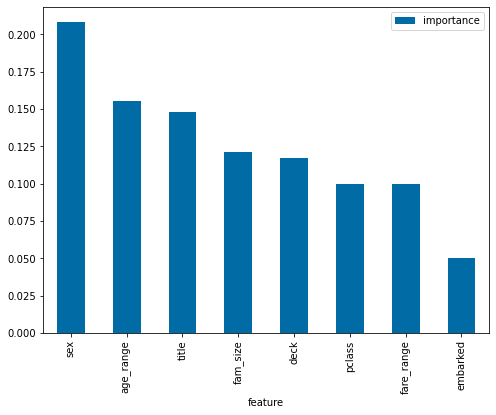

In [17]:
fi.plot.bar();

embarked doesn't play a significant role in our random forest classifier predictor. 

A general rule is that, the more features you have, the more likely your model will suffer from overfitting and vice versa. We decide to remove it from the dataset and train the classifier again.

In [18]:
X_train = X_train.drop("embarked", axis = 1)
X_test = X_test.drop("embarked", axis = 1)

In [46]:
# df.drop("embarked", axis = 1)

,pclass,deck,fare_range,sex,title,age_range,fam_size,survived
0,1,1,4,1,0,2,1,1
1,1,2,4,0,3,0,4,1
2,1,2,4,1,0,0,4,0
3,1,2,4,0,1,2,4,0
4,1,2,4,1,2,2,4,0
...,...,...,...,...,...,...,...,...
1304,3,5,2,1,0,1,2,0
1305,3,5,2,1,0,1,2,0
1306,3,5,0,0,1,2,1,0
1307,3,6,0,0,1,2,1,0


We use *GridSearch* to select the heperparameter that improve the accuracy of the model. Grid Search does this by fitting every combination of parameters and selecting the best ones.

Hyperparameter tuning for the parameters:
    
- **n_estimators**: number of trees in the foreset
- **criterion**: function to measure the quality of a split. Supported criteria are gini for the Gini impurity and entropy for the information gain.
- **max depth**: max number of levels in each decision tree  

We find the individual depths of each tree that it is part of the random forest.

In [20]:
max_depth = set([est.tree_.max_depth for est in RFC_model.estimators_])
print(f'Max number of levels in each decision tree is: {max_depth}')

Max number of levels in each decision tree is: {12, 13, 14, 15, 16, 17, 18, 19, 20}


In [21]:
params= {"n_estimators":[100, 300, 500],
         "criterion": ["gini", "entropy"],
         "max_depth": list(max_depth)}

RFC_model_sel = GridSearchCV(RFC_model, params)
RFC_model_sel.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [12, 13, 14, 15, 16, 17, 18, 19, 20],
                         'n_estimators': [100, 300, 500]})

In [22]:
print(f'Best parameters Random Forest')
RFC_model_sel.best_params_

Best parameters Random Forest


{'criterion': 'gini', 'max_depth': 12, 'n_estimators': 300}

### Define the model with its best parameters

In [70]:
best_RFC_model = RandomForestClassifier(random_state = 1,  
                            n_estimators= RFC_model_sel.best_params_['n_estimators'], 
                            max_depth = RFC_model_sel.best_params_['max_depth'], 
                            criterion = RFC_model_sel.best_params_['criterion'])
best_RFC_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=12, n_estimators=300, random_state=1)

### Prediction and evaluation

In [71]:
y_pred = best_RFC_model.predict(X_test)

 **Accuracy** the ratio of the True predicted values to the Total predicted values.

In [72]:
# Accuracy
print(f'Accuracy: {round(accuracy_score(y_test, y_pred)*100,2,)} %')

Accuracy: 79.64 %


The accuracy confirms the results of the cross validation.

Appearenly, we have a not pretty good accuracy. But, it could not be a great measure of performance because, as seen before, the classes are a bit imbalanced (60vs40).

## Metrics

To get even more deeply into model performance and see the what kind of errors the model made, we not only check accuracy but also precision, recall and F1 score printing the classification report.

Model Evaluation Metrics:
 
   - **Precision** for class 1 is, out of all predicted class values like 1, how many actually belong to class 1.
   
   
   - **Recall** for class 1 is, out of all the values that actually belong to class 1, how much is predicted as class 1.
   
   
   - **F1-score** seeks a balance between precision and recall, it takes into account false negatives and false positives.

In [26]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.90      0.84       243
           1       0.79      0.63      0.70       150

    accuracy                           0.80       393
   macro avg       0.80      0.77      0.77       393
weighted avg       0.80      0.80      0.79       393



#### Conclusions

In [27]:
print(f'Our model predicts {round(precision_score(y_test, y_pred)*100)}% of the time a passengers survival correctly (precision).')

Our model predicts 79% of the time a passengers survival correctly (precision).


In [28]:
print(f'The recall tells us that it predicted the survival of {round(recall_score(y_test, y_pred)*100)}% of the people who actually survived.')

The recall tells us that it predicted the survival of 63% of the people who actually survived.


In [29]:
print(f'f1 score, that is a combination between precision and recall, is {round(f1_score(y_test, y_pred)*100)}%. Not too high but not too bad for the first try!')

f1 score, that is a combination between precision and recall, is 70%. Not too high but not too bad for the first try!


As we can see in the classification report, the model predicts Not-Survived passengers (0) better than Survived ones (1), probably due to the slight imbalance of the dataset.

### Confusion Matrix

Now we will proceed on checking the **confusion matrix**, which will help us to see how many prediction are correct/ incorrect.

A confusion matrix tells us the performance of our algorithm, where the rows are the actual data and the columns the predictions.

- TP = True Positive Real: Survived | Prediction: Survived

- FP = False Positive Real: No Survived | Prediction: Survived

- TN = True Negative Real: No Survived | Prediction: No Survived

- FN = False Negative Real: Survived | Prediction: No Survived

In [30]:
# Constants 
col = 'coolwarm'
xticks = ['N','P']
yticks = ['N','P']

In [65]:
def confusion_mtx(y_test, y_pred, pal, xticks, yticks):

    '''
    Function that returns:
    - Viz of the confusion matrix
    - Results of the confusion matrix
    '''

    print(f'Confusion Matrix')
    cm = confusion_matrix(y_test, y_pred);
    # print(cm)

    print(45*'-')

    # Viz
    plt.figure(figsize=(5,4))
    res = sns.heatmap(cm, annot=True, vmin=0.0, vmax=1000, fmt='.1f', cmap = pal)

    plt.xticks([0.5,1.5], xticks, va='center')
    plt.yticks([0.5,1.5], yticks, va='center')
    plt.xlabel('PREDICT VALUES', fontsize=12)
    plt.ylabel('TEST VALUES', fontsize=12);

    TN = cm[0][0]
    FN = cm[1][0]
    TP = cm[1][1]
    FP = cm[0][1]
    
    
    # Results
    print(f'TN: {TN} ({round(cm[0][0]*100/sum(cm[:,0]))}%)') 
    
    print(f'FN: {FN} ({round(cm[1][0]*100/sum(cm[:,0]))}%)')

    print(f'TP: {TP} ({round(cm[1][1]*100/sum(cm[:,1]))}%)')
    print(f'FP: {FP} ({round(cm[0][1]*100/sum(cm[:,1]))}%)')
    
    return TN, FN, TP, FP

Confusion Matrix
---------------------------------------------
TN: 218 (80%)
FN: 55 (20%)
TP: 95 (79%)
FP: 25 (21%)


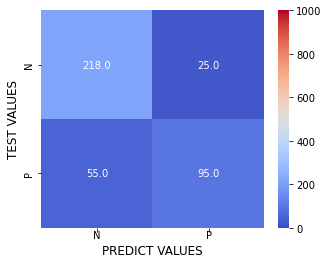

In [66]:
TN, FN, TP, FP = confusion_mtx(y_test, y_pred, col, xticks, yticks)

In [33]:
# u_test, f_test = np.unique(y_test, return_counts = True)

In [34]:
# u_test

In [35]:
# f_test

In [36]:
# u_pred, f_pred = np.unique(y_pred, return_counts = True)

In [37]:
# u_pred

In [38]:
# f_pred

#### Conclusions

In [39]:
print(f'--- Not Survived Predictions (0) ---')
print(f'The first column is about the not-survived-predictions (0): {TN} passengers were correctly classified as not survived (true negatives) and {FP} where wrongly classified as not survived (false positives).\n')

print(f'--- Survived Predictions (1) ---')
print(f'The second column is about the survived-predictions (1): {FN} passengers were wrongly classified as survived (false negatives) and {TP} where correctly classified as survived (true positives)')

--- Not Survived Predictions (0) ---
The first column is about the not-survived-predictions (0): 218 passengers were correctly classified as not survived (true negatives) and 25 where wrongly classified as not survived (false positives).

--- Survived Predictions (1) ---
The second column is about the survived-predictions (1): 55 passengers were wrongly classified as survived (false negatives) and 95 where correctly classified as survived (true positives)


### ROC curve

The **ROC AUC Curve** plots the true positive rate (also called recall) against the false positive rate (ratio of incorrectly classified negative instances).

In [40]:
#define metrics
y_pred_prob = best_RFC_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

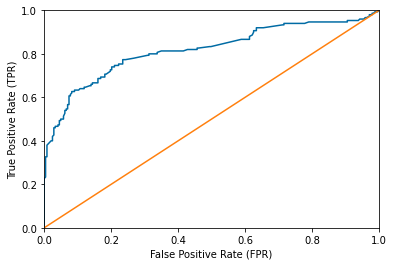

In [41]:
# plotting them against each other
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, label=label)
    plt.plot([0, 1], [0, 1])
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')

plt.figure(figsize=(6, 4))
plot_roc_curve(fpr, tpr)
plt.show()

The more that the curve hugs the top left corner of the plot, the better the model does at classifying the data into categories. The closer AUC is to 1, the better the model. 

In [42]:
roc_score = roc_auc_score(y_test, y_pred_prob)
print(f'ROC-AUC score: {round(roc_score*100)}%. Not a bad score!')

ROC-AUC score: 82%. Not a bad score!


## Final conclusions

The class imbalance, along with an improvable EDA, lead to us obtaining:

~**80% accuracy**

~**71% f1-score** 

~**82% ROC-AUC score**

The model is quite good in predict the probability of survival of passengers but there is still room for improvement. 

Some examples of improvements could be:

- a more extensive exploratory data analysis by comparing and plotting more features;

- the reduction of imbalance data

- some deeper hyperparameter tuning.

### References

- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
- https://towardsdatascience.com/understanding-random-forest-58381e0602d2
- https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74